# Setup

In [4]:
!pip install git+https://github.com/neelnanda-io/Easy-Transformer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/neelnanda-io/Easy-Transformer to /tmp/pip-req-build-daha3ir6
  Running command git clone -q https://github.com/neelnanda-io/Easy-Transformer /tmp/pip-req-build-daha3ir6
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 41 kB 452 kB/s 
     |████████████████████████████████| 1.9 MB 8.8 MB/s 
     |████████████████████████████████| 237 kB 73.7 MB/s 
     |████████████████████████████████| 451 kB 78.0 MB/s 
     |████████████████████████████████| 5.8 MB 72.5 MB/s 
     |████████████████████████████████| 212 kB 81.2 MB/s 
     |████████████████████████████████| 132 kB 97.8 MB/s 
     |████████████████████████████████| 182 kB 86.6 MB/s 
     |████████████████████████████████| 127 kB 33.8 MB/s 
     |████████████████████████████████| 51 kB 7.3 MB/s 
  

In [5]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
import tqdm.notebook as tqdm

import random
import time

# from google.colab import drive
from pathlib import Path
import pickle
import os


import matplotlib.pyplot as plt

%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go

from torch.utils.data import DataLoader

from functools import *
import pandas as pd
import gc
import collections
import copy

# import comet_ml
import itertools
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer
import dataclasses
import datasets

In [8]:
from easy_transformer.utils import (
    gelu_new,
    to_numpy,
    get_corner,
    lm_cross_entropy_loss,
)  # Helper functions
from easy_transformer.hook_points import (
    HookedRootModule,
    HookPoint,
)  # Hooking utilities
from easy_transformer import EasyTransformer, EasyTransformerConfig

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [10]:
from transformers import AutoModelForCausalLM

model_name = "solu-8l-old"
model = EasyTransformer.from_pretrained(model_name).to(device)

Loading model: solu-8l-old


Downloading:   0%|          | 0.00/767 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/828M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/156 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/457k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

Using pad_token, but it is not set yet.


Moving model to device:  cuda
Finished loading pretrained model solu-8l-old into EasyTransformer!
Moving model to device:  cuda


In [11]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [12]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer

aug_model_checkpoint = "distilbert-base-uncased"
aug_model = AutoModelForMaskedLM.from_pretrained(aug_model_checkpoint).to(device)
aug_tokenizer = AutoTokenizer.from_pretrained(aug_model_checkpoint)

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Code

In [13]:
import requests
import re

parser = re.compile("<span class='token' style='background-color:rgb\([0-9]{1,3}, [0-9]{1,3}, [0-9]{1,3}\)' >")
def get_snippets(model_name, layer, neuron):
  """Get the max activating dataset examples for a given neuron in a model"""
  base_url = f"https://lexoscope.io/{model_name}/{layer}/{neuron}.html"

  response = requests.get(base_url)
  webpage = response.text
  parts = parser.split(webpage)
  snippets = []
  snippet = ""
  for i, part in enumerate(parts):
    if i == 0:
      continue
    token, end = part.split("</span>")
    snippet += token

    if end.startswith("</div>"):
      snippets.append(snippet)
      snippet = ""
      continue
    
  if len(snippets) != 20:
    raise
  return snippets

In [14]:
from string import punctuation

class WordTokenizer:
  """Simple tokenizer for splitting text into words"""

  def __init__(self, split_tokens, stick_tokens):
    self.split_tokens = split_tokens
    self.stick_tokens = stick_tokens

  def __call__(self, text):
    return self.tokenize(text)

  def is_split(self, char):
    """Split on any non-alphabet chars unless excluded, and split on any specified chars"""
    return char in self.split_tokens or (not char.isalpha() and char not in stick_tokens)
  
  def tokenize(self, text):
    """Tokenize text, preserving all characters"""
    tokens = []
    current_token = ""
    for char in text:
      if self.is_split(char):
        tokens.append(current_token)
        tokens.append(char)
        current_token = ""
        continue
      current_token += char
    tokens.append(current_token)
    tokens = [token for token in tokens if token]
    return tokens

stick_tokens = {"'"}
word_tokenizer = WordTokenizer(set(), stick_tokens)

In [15]:
import copy
from nltk.corpus import stopwords
from string import punctuation
import re
from scipy.special import softmax

class ContextualAugmenter:
  """Uses BERT to generate variations on input text by masking words and substituting with most likely predictions"""

  def __init__(self, model, model_tokenizer, word_tokenizer, neuron_model, device="cuda:0"):
    self.model = model
    self.model_tokenizer = model_tokenizer
    self.stops = set(stopwords.words('english'))
    self.punctuation_set = set(punctuation)
    self.to_strip = " " + punctuation
    self.word_tokenizer = word_tokenizer
    self.device = device

  def augment(self, text, max_char_position=None, exclude_stopwords=False, n=5, mask_num=1, important_tokens=None, all_but_important=False, only_important=False, **kwargs):
    """Generate new texts given an initial text and a masking scheme by auto-regressively predicting each masked token with BERT"""

    if all_but_important and important_tokens is None:
      raise ValueError("When all_but_important is True you must provide one or more important_tokens")

    if only_important and important_tokens is None:
      raise ValueError("When only_important is True you must provide one or more important_tokens")

    if only_important and all_but_important:
      raise ValueError("only_important and all_but_important are not allowed to be True at the same time")

    joiner = ""
    tokens = self.word_tokenizer(text)
    
    new_texts = []
    positions = []

    important_tokens = {token.strip(self.to_strip).lower() for token in important_tokens}

    seen_prompts = set()

    for i, token in enumerate(tokens):
      norm_token = token.strip(self.to_strip).lower()
      if not token or word_tokenizer.is_split(token) or (exclude_stopwords and norm_token in self.stops) or (important_tokens is not None and norm_token not in important_tokens):
        continue

      masked_tokens = copy.deepcopy(tokens)
      masked = 0
      
      if not all_but_important and not only_important:
        # Mask mask_num consecutive tokens
        masking_index = 0
        while masked < mask_num and i + masking_index < len(masked_tokens):
          if not word_tokenizer.is_split(masked_tokens[i + masking_index]):
            masked_tokens[i + masking_index] = "[MASK]"
            masked += 1
          masking_index += 1

      else:
        for j, cand_token in enumerate(tokens):
          norm_cand_token = cand_token.strip(self.to_strip).lower()
          # Basic token checks plus check if the token is important and therefore whether it should be masked
          if (not cand_token or word_tokenizer.is_split(cand_token) or 
              (exclude_stopwords and norm_cand_token in self.stops) or 
              (norm_cand_token in important_tokens and all_but_important) or 
              (norm_cand_token not in important_tokens and only_important)):
            continue
          masked_tokens[j] = "[MASK]"
          masked += 1
        
      before = tokens[:i]
      before_text = joiner.join(before)
      position = len(before_text)

      # Don't bother if we're beyond the max activating token, as these tokens have no effect on the activation
      if max_char_position is not None and position > max_char_position:
        break

      start_masked_text = joiner.join(masked_tokens)
      masked_matrix = [[copy.deepcopy(start_masked_text) for _ in range(n)] for _ in range(masked + 1)]

      for j in range(masked):
        masked_texts = masked_matrix[j]
        inputs = self.model_tokenizer(masked_texts, padding=True, return_tensors="pt").to(self.device)
        token_probs = softmax(self.model(**inputs).logits.cpu().detach().numpy(), axis=-1)
        inputs = inputs.to("cpu")

        chosen_tokens = set()
        
        for k in range(n):
          # Get the index of the first masked token
          mask_token_index = np.argwhere(inputs["input_ids"][k] == self.model_tokenizer.mask_token_id)[0, 0]
          mask_token_probs = token_probs[k, mask_token_index, :]
          # We negate the array before argsort to get the largest, not the smallest, logits
          top_probs = -np.sort(-mask_token_probs).transpose()
          top_tokens = np.argsort(-mask_token_probs).transpose()

          # Substitute the given token with the best predictions
          for l, top_token in enumerate(top_tokens):
            next_top_prob = top_probs[l + 1]
            candidate_token = self.model_tokenizer.decode(top_token)
            if candidate_token in chosen_tokens and next_top_prob > 0.00001:
              continue

            # Check that the predicted token isn't the same as the token that was already there
            normalised_candidate = candidate_token.strip(self.to_strip).lower() if candidate_token not in self.punctuation_set else candidate_token
            normalised_token = token.strip(self.to_strip).lower() if token not in self.punctuation_set else token
            
            if normalised_candidate != normalised_token:
              chosen_token = candidate_token
              chosen_tokens.add(chosen_token)
              break

          masked_matrix[j + 1][k] = masked_texts[k].replace(self.model_tokenizer.mask_token, candidate_token, 1).replace(" ##", "")

      for new_prompt in masked_matrix[-1]:
        if new_prompt in seen_prompts:
          continue
        new_texts.append(new_prompt)
        positions.append(position)
        seen_prompts.add(new_prompt)

      if all_but_important or only_important:
        break       
    
    return new_texts, positions

In [16]:
contextual_aug = ContextualAugmenter(aug_model, aug_tokenizer, word_tokenizer, model)

In [17]:
from pprint import pprint
from collections import defaultdict
from string import punctuation
import re
import copy

splitter = re.compile("[\.!\\n]")

def sentence_tokenizer(str_tokens):
  """Split tokenized text into sentences"""
  sentences = []
  sentence = []
  sentence_to_token_indices = defaultdict(list)
  token_to_sentence_indices = {}
  
  for i, str_token in enumerate(str_tokens):
    sentence.append(str_token)
    sentence_to_token_indices[len(sentences)].append(i)
    token_to_sentence_indices[i] = len(sentences)
    if splitter.search(str_token) is not None or i + 1 == len(str_tokens):
      sentences.append(sentence)
      sentence = []    

  return sentences, sentence_to_token_indices, token_to_sentence_indices


def prune(model, layer, neuron, prompt, max_length=1024, proportion_threshold=-0.6, absolute_threshold=None, window=0, **kwargs):
  """Prune an input prompt to the shortest string that preserves x% of neuron activation on the most activating token."""

  prepend_bos = True
  tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
  str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)

  if len(tokens[0]) > max_length:
    tokens = tokens[0, :max_length].unsqueeze(0)

  logits, cache = model.run_with_cache(tokens)
  activations = cache[layer][0, :, neuron]

  initial_max = torch.max(activations).cpu().item()
  initial_argmax = torch.argmax(activations).cpu().item()

  sentences, sentence_to_token_indices, token_to_sentence_indices = sentence_tokenizer(str_tokens)

  max_sentence_index = token_to_sentence_indices[initial_argmax]
  relevant_str_tokens = [str_token for sentence in sentences[:max_sentence_index + 1] for str_token in sentence]

  shortest_successful_prompt = None
  for i, str_token in reversed(list(enumerate(relevant_str_tokens[:max(0, initial_argmax - window + 1)]))):
    truncated_prompt = relevant_str_tokens[i:]

    joined = "".join(truncated_prompt)
    
    truncated_tokens = model.to_tokens(joined, prepend_bos=prepend_bos)
    logits, cache = model.run_with_cache(truncated_tokens)
    truncated_activations = cache[layer][0, :, neuron]
    truncated_argmax = torch.argmax(truncated_activations).cpu().item() + i
    if prepend_bos:
      truncated_argmax -= 1
    truncated_max = torch.max(truncated_activations).cpu().item()

    shortest_prompt = truncated_prompt

    if truncated_argmax == initial_argmax and (
        (truncated_max - initial_max) / initial_max > proportion_threshold or 
        (absolute_threshold is not None and truncated_max >= absolute_threshold)):        
      shortest_successful_prompt = truncated_prompt
      break

  pruned_sentence = "".join(shortest_successful_prompt) if shortest_successful_prompt is not None else None
  
  return pruned_sentence


def augment(model, layer, index, prompt, aug, max_length=1024, inclusion_threshold=-0.5, exclusion_threshold=-0.5, **kwargs):
  """Generate variations of a prompt using an augmenter"""
  prepend_bos = True
  tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
  str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)

  if len(tokens[0]) > max_length:
    tokens = tokens[0, :max_length].unsqueeze(0)

  logits, cache = model.run_with_cache(tokens)
  activations = cache[layer][0, :, index]

  initial_max = torch.max(activations).cpu().item()
  initial_argmax = torch.argmax(activations).cpu().item()
  max_char_position = len("".join(str_tokens[int(prepend_bos):initial_argmax + 1]))

  positive_prompts = [(prompt, initial_max, 1)]
  negative_prompts = []
  
  aug_prompts, aug_positions = aug.augment(prompt, max_char_position=max_char_position, **kwargs)
  if not aug_prompts:
    return positive_prompts, negative_prompts
    
  aug_tokens = model.to_tokens(aug_prompts, prepend_bos=prepend_bos)

  aug_logits, aug_cache = model.run_with_cache(aug_tokens)
  all_aug_activations = aug_cache[layer][:, :, index]

  for aug_prompt, char_position, aug_activations in zip(aug_prompts, aug_positions, all_aug_activations):
    aug_max = torch.max(aug_activations).cpu().item()
    aug_argmax = torch.argmax(aug_activations).cpu().item()

    # TODO implement this properly - when we mask multiple tokens, if they cross the max_char_position this will not necessarily be correct
    if char_position < max_char_position:
      new_str_tokens = model.to_str_tokens(aug_prompt, prepend_bos=prepend_bos)
      aug_argmax += len(new_str_tokens) - len(str_tokens)

    proportion_drop = (aug_max - initial_max) / initial_max

    if proportion_drop >= inclusion_threshold:
      positive_prompts.append((aug_prompt, aug_max, proportion_drop))
    elif proportion_drop < exclusion_threshold:
      negative_prompts.append((aug_prompt, aug_max, proportion_drop))

  return positive_prompts, negative_prompts

In [26]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt


def visualise(tokens_and_importances, tokens_and_activations, title=None):
  """Visualise relative token activation and importance"""
  data = {token: [activation, importance] for (token, _, importance), (_, activation) in zip(tokens_and_importances, tokens_and_activations) if token != "<|endoftext|>"}
  df = pd.DataFrame(data, index=["Activation", "Importance"])
  plt.figure(figsize=[int(len(tokens_and_activations) * 1.5), 1.5])
  sns.heatmap(df, vmin=0, vmax=1, xticklabels=True, annot=True)
  if title is not None:
    plt.title(title)

In [19]:
def measure_importance(model, layer, neuron, prompt, max_length=1024, max_activation=None, masking_token=1, threshold=0.8, **kwargs):
  """Compute a measure of token importance by masking each token and measuring the drop in activation on the max activating token"""
  
  prepend_bos = True
  tokens = model.to_tokens(prompt, prepend_bos=prepend_bos)
  str_tokens = model.to_str_tokens(prompt, prepend_bos=prepend_bos)

  if len(tokens[0]) > max_length:
    tokens = tokens[0, :max_length].unsqueeze(0)

  logits, cache = model.run_with_cache(tokens)
  activations = cache[layer][0, :, neuron]

  initial_max = torch.max(activations).cpu().item()
  initial_argmax = torch.argmax(activations).cpu().item()

  if max_activation is None:
    max_activation = initial_max
  scale = min(1, initial_max / max_activation)

  tokens_and_activations = [(str_token, round(activation.cpu().item() / max_activation, 3)) for str_token, activation in zip(str_tokens, activations)]
  important_tokens = []
  tokens_and_importances = []

  shortest_successful_prompt = None
  for i, str_token in enumerate(str_tokens):
    joined = "".join(str_tokens)
    
    masked_tokens = model.to_tokens(joined, prepend_bos=False)

    masked_tokens[0, i] = masking_token

    logits, cache = model.run_with_cache(masked_tokens)
    masked_activations = cache[layer][0, :, neuron]
    masked_max = masked_activations[initial_argmax].cpu().item()
    normalised_activation = (1 - (masked_max / initial_max))
    
    tokens_and_importances.append((str_token, masked_max, normalised_activation))
    if normalised_activation >= threshold and str_token != "<|endoftext|>":
      important_tokens.append(str_token)

  return tokens_and_importances, initial_max, important_tokens, tokens_and_activations

In [20]:
def augment_and_visualise(model, layer, neuron, aug, pruned_prompt, **kwargs):
  tokens_and_importances, max_act, important_tokens, tokens_and_activations = measure_importance(model, layer, neuron, pruned_prompt)
    
  positive_prompts, negative_prompts = augment(model, layer, neuron, pruned_prompt, aug, important_tokens=set(important_tokens), **kwargs)  
  for i, (prompt, activation, change) in enumerate(positive_prompts):
    title = prompt
    if i == 0:
      title = "Original - " + prompt
    tokens_and_importances, _, _, tokens_and_activations = measure_importance(model, layer, neuron, prompt, max_activation=max_act)
    visualise(tokens_and_importances, tokens_and_activations, title=title)

  for prompt, activation, change in negative_prompts:
    tokens_and_importances, _, _, tokens_and_activations = measure_importance(model, layer, neuron, prompt, max_activation=max_act)
    visualise(tokens_and_importances, tokens_and_activations, title=prompt)


def run(model, layer, neuron, aug=contextual_aug, snippets=None, num_examples=5, example_indexes=None, **kwargs):
  """For a given neuron, grab the max activating dataset examples, run them through the pruning and augmentation steps, and visualise the results"""
  if snippets is None:
    snippets = get_snippets("solu-8l-old", layer, neuron)
    if example_indexes is not None:
      snippets = [snippet for i, snippet in enumerate(snippets) if i in example_indexes]
    else:
      snippets = snippets[:num_examples]

  if isinstance(layer, int):
    layer = f"blocks.{layer}.mlp.hook_mid"

  for snippet in snippets:
    pruned_prompt = prune(model, layer, neuron, snippet, **kwargs)

    if pruned_prompt is None:
      continue  

    augment_and_visualise(model, layer, neuron, aug, pruned_prompt, **kwargs)

# Walkthrough

This is a step-by-step example of the process pruning and varying maximally activating dataset examples to explore the behaviour of a specific neuron in a language model.

The starting prompt is defined below. This prompt is the maximally activating dataset example for neuron 1 in layer 3 of solu-8l-old - see https://lexoscope.io/solu-8l-old/3/1.html for more dataset examples for this neuron, with token highlighting based on neuron activation.

For this prompt, the max activating token is `cross`, in the context `The thought didn't even cross my mind.` The aim of the algorithm is to take this lengthy dataset example, prune it to just the necessary context whilst preserving neuron activation, and then search for similar prompts and measure how they change the neuron activation.

In [21]:
starting_prompt = r"""
<|endoftext|>.

"I will. Same to you."

He tells me that he loves me, and then I hang up just as I arrive at Wes's house.

I park in the driveway next to his bike, not bothering to hide my Jeep down the road like usual. I know all about our past, and frankly, now that Wes knows too, his mother's threats are useless. She can't bully me out of Wes's life.

I've made mistakes, not all of them completely my fault, but I can try not to make any more. I'm not sure where we stand relationship-wise, but we'll figure it out. We might even make the right decisions this time. For now, we just have to save the world. No pressure.

I quickly dial Nathan, but he doesn't answer, making me nervous. I tell him to call me back, and that I'm at Wes's house. I push the phone into my pocket and climb out of the Jeep.

Wes waits for me at his door, smiling and looking a little nervous. I wonder if he thought I was going to turn onto the freeway and drive away instead of coming here. The thought didn't even cross my mind. I would have followed him anywhere.

"Parents aren't home," he says, watching my approach. "In case you were worried."

"Now you won't have to lock the door," I say, and stop in front of him.

Wes's smile fades. "I always lock the door," he replies, and turns to push inside his basement apartment.
"""

First, we pass the prompt to the `prune` function. This function splits the prompt into sentences, before taking all sentences up to and including the sentence containing the token with the highest neuron activation - i.e., the new prompt will contain everything up to the end of `...didn't even cross my mind.`

It then truncates that smaller context up to the max activating token - i.e., `cross my mind.`, and passes this truncated prompt to the model. It then measures the activation of the neuron on the key token `cross`, and computes the change in activation relative to the initial activation on this token. If this change is a decrement larger than a user-defined threshold, typically about -50%, then the prior token is added to the truncated prompt - in this case producing `even cross my mind` - and this process is repeated, until the activation on the key token is sufficient to pass this condition.

In [22]:
pruned_prompt = prune(model, "blocks.3.mlp.hook_mid", 1, starting_prompt)
print("Pruned prompt:", pruned_prompt)

Pruned prompt:  The thought didn't even cross my mind.


Once we have a pruned prompt, we then use a simple method of perturbing the input to compute a measure of importance for each token. The function `measure_importance` masks each token in turn with the special `<|padding|>` token, and measures the change in neuron activation on the key token. The importance $I_k$ for the $k^{th}$ token is then calculated as $I_k = 1 - (\frac{a_{masked}}{a_{key}})$, where $a_{masked}$ is the activation of the neuron on the key token when token $k$ is masked, and $a_{key}$ is the activation of the neuron on the key token on the unmasked prompt.

We then visualise these token importances along with the relative activation $R$ of the neuron on each token in the prompt, where $R = \frac{a_k}{a_{key}}$, where $a_k$ is the activation of the neuron on the $k^{th}$ token and again $a_{key}$ is the activation of the neuron on the key token on the unmasked prompt.

`measure_importance` also returns the important tokens for a prompt, which are defined as the tokens with an importance above a user-defined threshold. 0.8 works well empirically.

Important tokens: [' thought', ' cross']


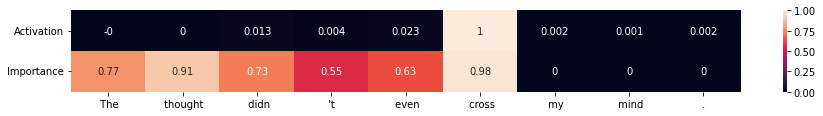

In [27]:
tokens_and_importances, max_act, important_tokens, tokens_and_activations = measure_importance(model, "blocks.3.mlp.hook_mid", 1, pruned_prompt)
visualise(tokens_and_importances, tokens_and_activations)
print("Important tokens:", important_tokens)

Finally, the pruned prompt is used as a starting point to generate more varied inputs, to help explore what does and doesn't activate the neuron. The basic method masks a token in the prompt, then uses BERT to generate likely substitutions for that token and creates a new prompt with each of the top $n$ substitutes, provided they cross a probability threshold.

The default parameters for this augmentation step perform this substitution for each of the important tokens in turn. The new prompts then have the importance mechanism applied, and the relative activation of each token is computed. The relative activations are computed relative to the activation on the key token of the starting prompt, which helps illustrate the change in the key token activation due to the substitution.

Below we see an example of the insight this can give into neuron function. By finding substitutes for the word `thought`, we see that the neuron still activates for synonyms of `thought`, although not as strongly. When we find substitutes for the key token `cross`, we see that the model will also activate on some other words that make sense in this context, like `escape` and `enter`, but the activation drops quite significantly on other words like `touch` and `occupy`. Looking at the differences between these words, it seems like this neuron responds more strongly to words that convey movement, which is not obvious from the initial example alone.

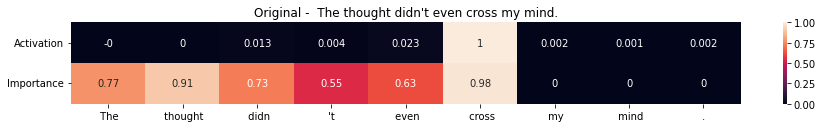

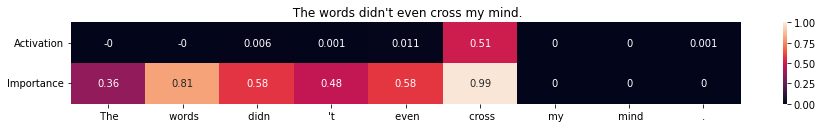

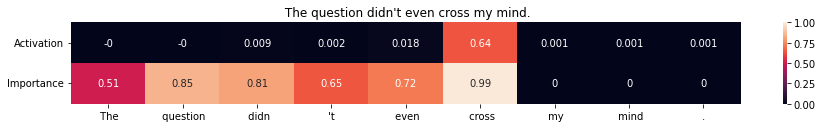

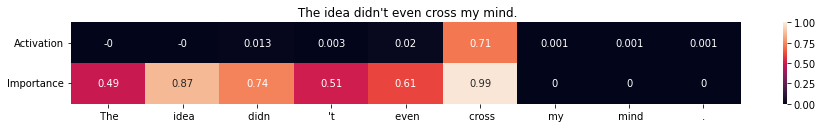

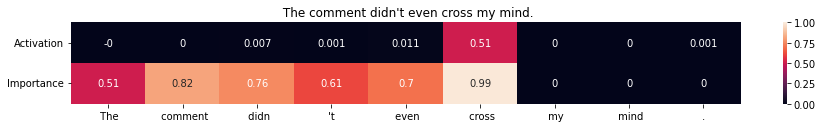

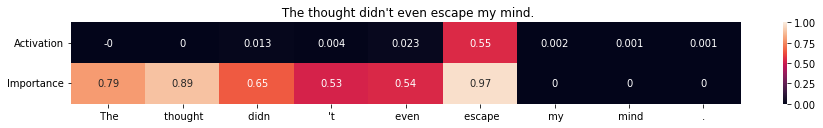

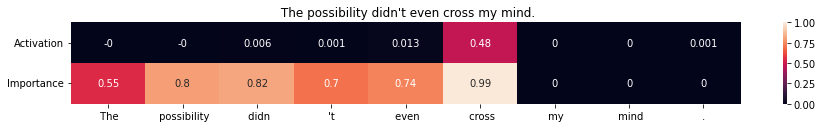

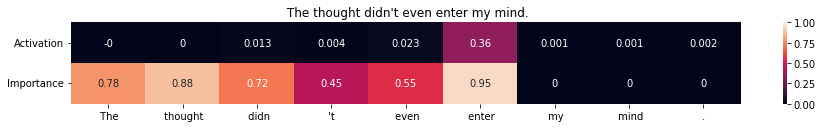

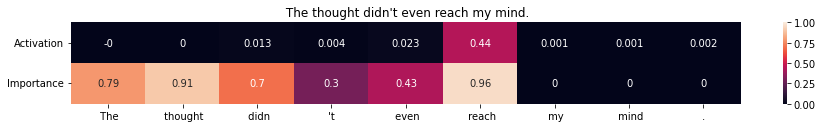

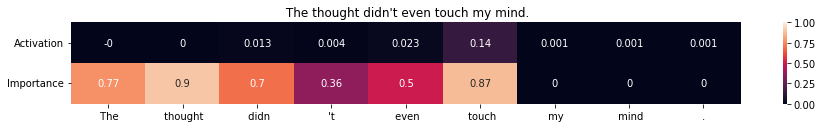

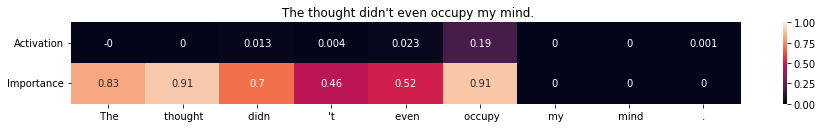

In [28]:
augment_and_visualise(model, "blocks.3.mlp.hook_mid", 1, contextual_aug, pruned_prompt, n=5)

The function also allows you to specify `mask_num`, which will mask `mask_num - 1` consecutive tokens after the important token. This helps to give greater variation in the generated prompts, but makes it harder to pinpoint exactly what has caused a change in activation.

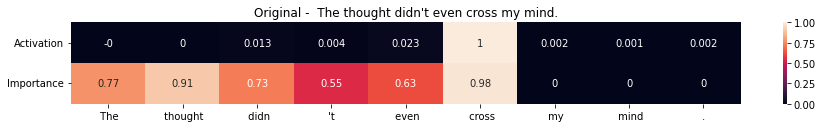

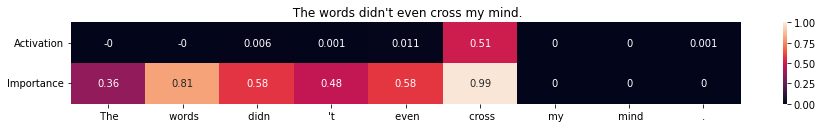

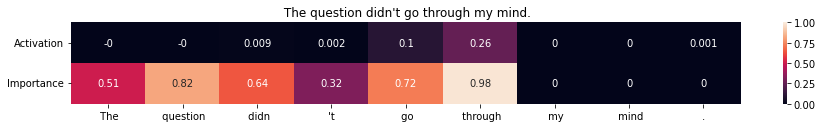

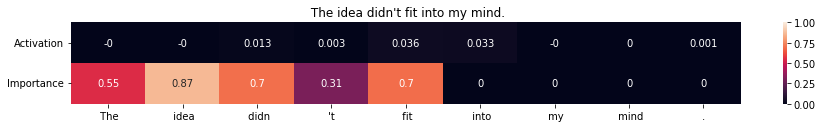

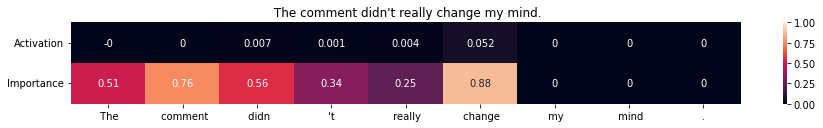

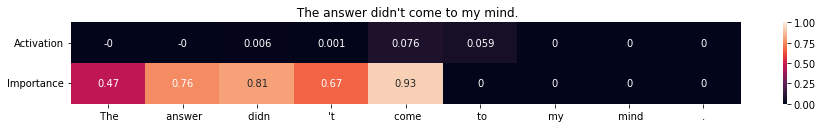

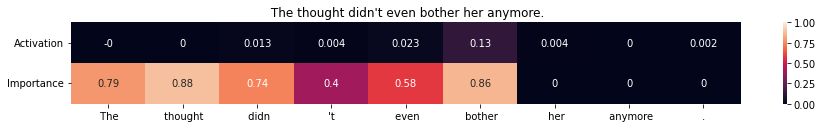

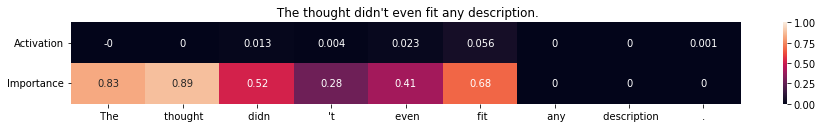

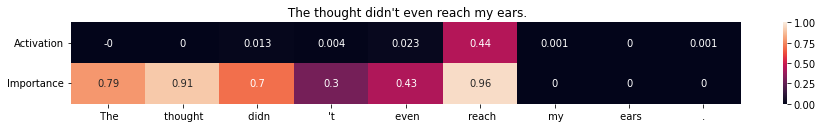

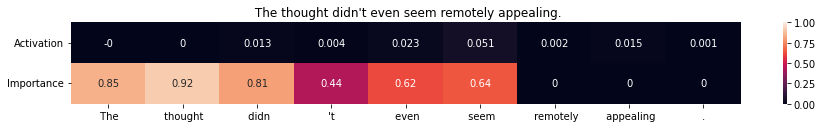

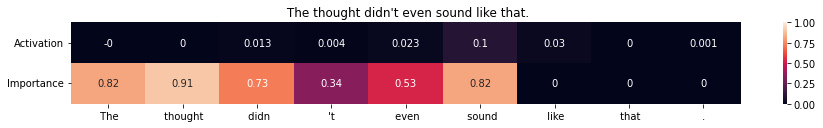

In [29]:
augment_and_visualise(model, "blocks.3.mlp.hook_mid", 1, contextual_aug, pruned_prompt, n=5, mask_num=3)

We can also choose to substitute the important tokens together, to again trade-off greater variety for less specific insight.  Or we can substitute all the unimportant tokens together, to see how changing the context but keeping the same important tokens affects neuron activation.

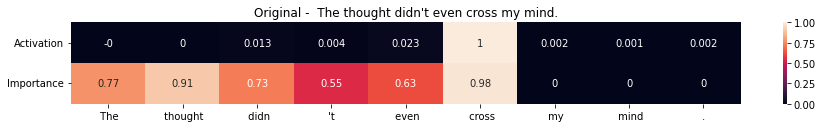

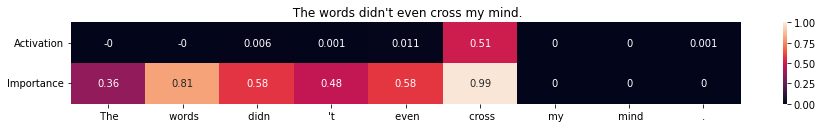

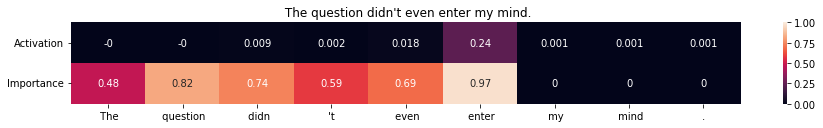

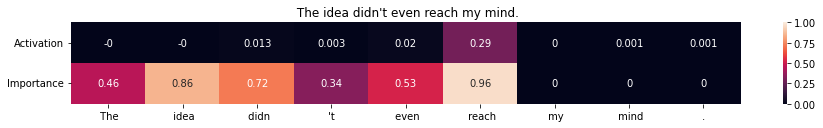

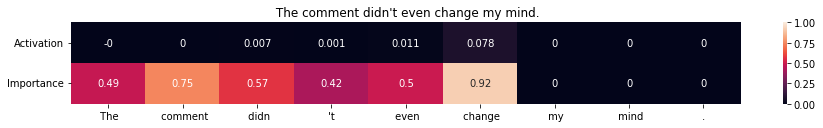

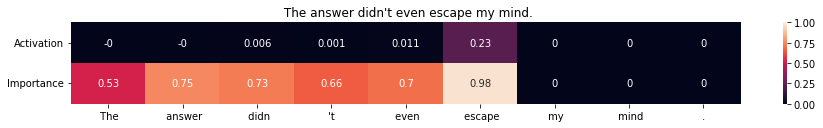

In [30]:
augment_and_visualise(model, "blocks.3.mlp.hook_mid", 1, contextual_aug, pruned_prompt, n=5, only_important=True)

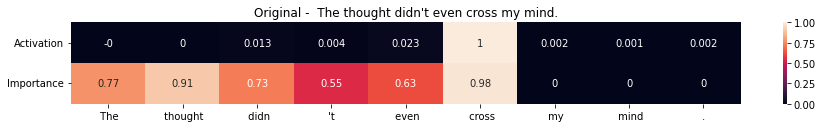

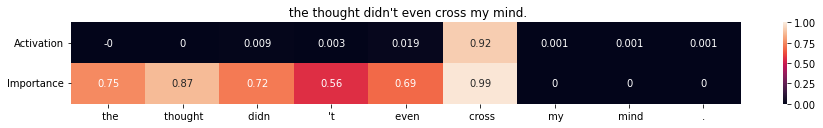

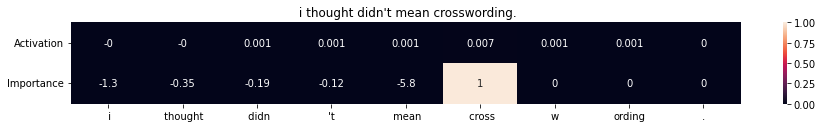

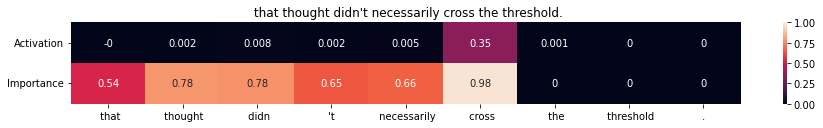

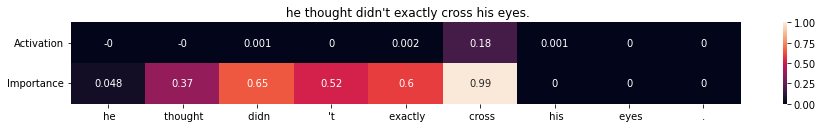

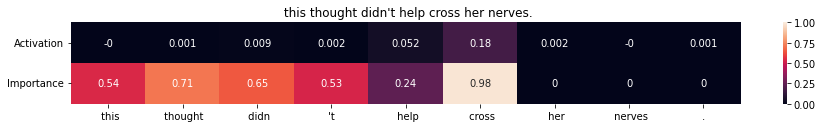

In [31]:
augment_and_visualise(model, "blocks.3.mlp.hook_mid", 1, contextual_aug, pruned_prompt, n=5, all_but_important=True)

We can easily run the full analysis for any given neuron by providing the model, the layer number, and the neuron index, and use the `kwargs` to control the parameters for each of the above functions.

Note that the analysis works better for some neurons than others - in particular, it works better for neurons that respond to natural language input, as opposed to neurons such as https://lexoscope.io/solu-8l-old/4/912.html, which responds to the `f` in inputs like `(bjc2017256f3)`.

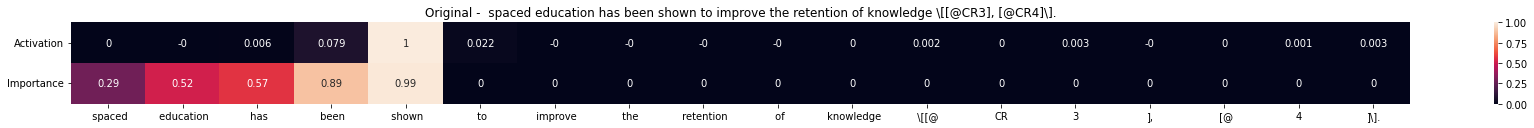

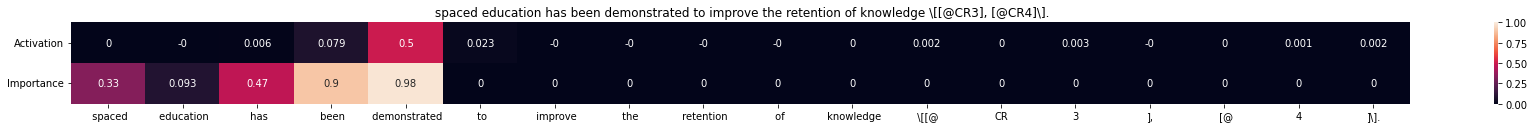

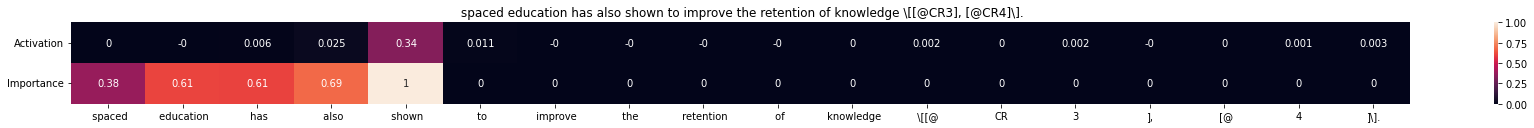

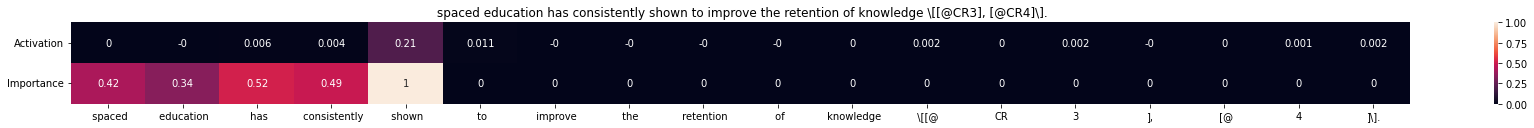

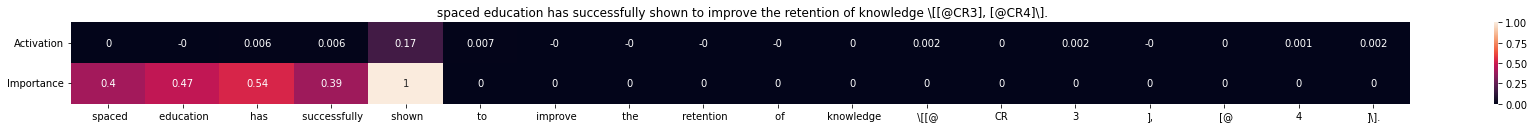

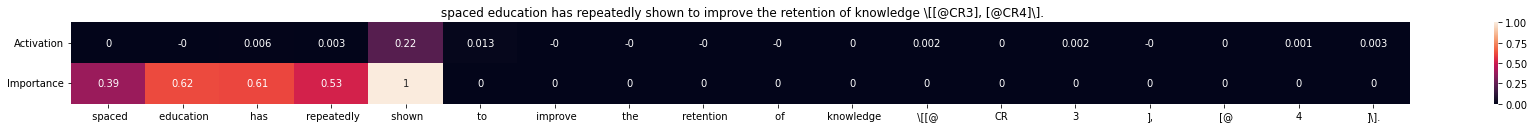

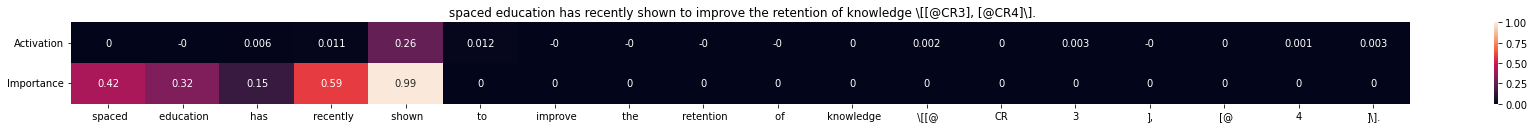

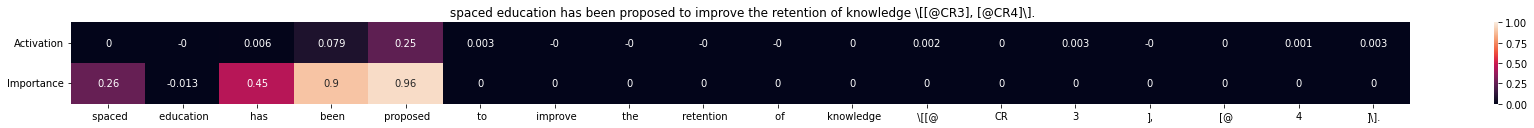

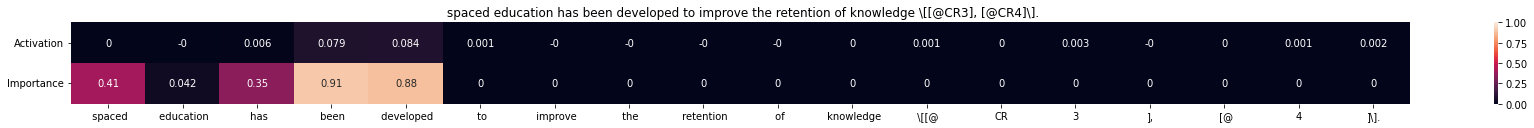

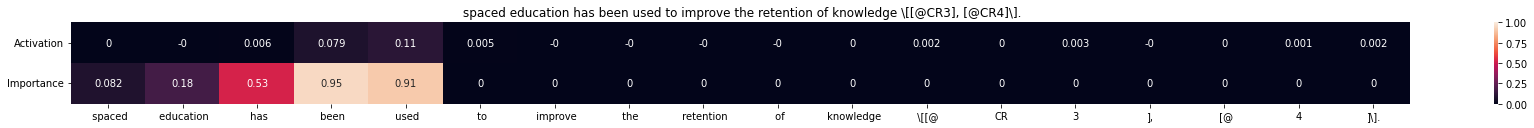

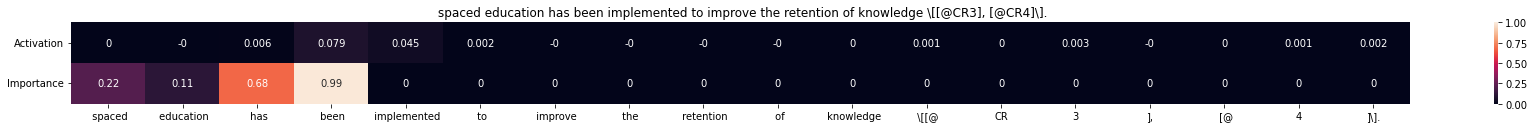

In [33]:
run(model, 3, 8, num_examples=1)